In [8]:
import pandas as pd

client_data = pd.read_csv('/Users/manhaawan/Documents/Energy Consumption Project/client.csv')
gas_prices = pd.read_csv('/Users/manhaawan/Documents/Energy Consumption Project/gas_prices.csv')
historical_weather = pd.read_csv('/Users/manhaawan/Documents/Energy Consumption Project/historical_weather.csv')
train = pd.read_csv('/Users/manhaawan/Documents/Energy Consumption Project/train.csv')


In [ ]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import xgboost as xgb



#Datetime Conversion
train["datetime"] = pd.to_datetime(train["datetime"], errors='coerce')
historical_weather["datetime"] = pd.to_datetime(historical_weather["datetime"], errors='coerce')
train["date"] = train["datetime"].dt.date
historical_weather["date"] = historical_weather["datetime"].dt.date

#Drop Duplicates
client_data = client_data.drop_duplicates(subset='data_block_id')
historical_weather = historical_weather.drop_duplicates(subset='data_block_id')
gas_prices = gas_prices.drop_duplicates(subset='data_block_id')

#Merge DataFrames
merge_dfs = [client_data, historical_weather, gas_prices]
merged_df = train.copy()
for df in merge_dfs:
    merged_df = merged_df.merge(df, on='data_block_id', how='left', suffixes=('', '_dup'))
merged_df = merged_df.loc[:, ~merged_df.columns.str.endswith('_dup')]

#Feature Engineering
merged_df["hour"] = merged_df["datetime"].dt.hour
merged_df["dayofweek"] = merged_df["datetime"].dt.dayofweek
merged_df["month"] = merged_df["datetime"].dt.month
merged_df = merged_df.sort_values(by=["prediction_unit_id", "datetime"])
merged_df["target_lag_24h"] = merged_df.groupby("prediction_unit_id")["target"].shift(24)
merged_df["target_rolling_24h"] = merged_df.groupby("prediction_unit_id")["target"].rolling(24).mean().reset_index(0, drop=True)

#Aggregate Weather
weather_daily = historical_weather.groupby("date").agg({
    "temperature": "mean",
    "shortwave_radiation": "mean",
    "cloudcover_total": "mean",
    "windspeed_10m": "mean",
    "dewpoint": "mean",
    "rain": "mean",
    "surface_pressure": "mean",
    "snowfall": "mean",
    "winddirection_10m": "mean",
    "direct_solar_radiation": "mean",
    "diffuse_radiation": "mean"
}).reset_index().rename(columns={
    "temperature": "daily_avg_temp",
    "shortwave_radiation": "daily_avg_radiation",
    "cloudcover_total": "daily_avg_cloudcover",
    "windspeed_10m": "daily_avg_wind",
    "dewpoint": "daily_avg_dewpoint",
    "rain": "daily_avg_rain",
    "surface_pressure": "daily_avg_pressure",
    "snowfall": "daily_avg_snowfall",
    "winddirection_10m": "daily_avg_winddirection",
    "direct_solar_radiation": "daily_avg_direct_radiation",
    "diffuse_radiation": "daily_avg_diffuse_radiation"
})
merged_df["date"] = pd.to_datetime(merged_df["datetime"]).dt.date
merged_df = merged_df.merge(weather_daily, on="date", how="left")
'''
#Filter to Consumption-Only
consumption_df = merged_df[merged_df["is_consumption"] == True].copy()

#Define Features
features = [
    "hour", "dayofweek", "month", "daily_avg_temp", "daily_avg_radiation",
    "daily_avg_cloudcover", "daily_avg_wind", "target_lag_24h",
    "target_rolling_24h", "lowest_price_per_mwh", "highest_price_per_mwh"
]

# Drop NA rows
consumption_df = consumption_df.dropna(subset=features + ["target"])
X = consumption_df[features].values
y = consumption_df["target"].values

#PCA (Optional, just for insight)
pca_features = [
    'highest_price_per_mwh', 'lowest_price_per_mwh', 'daily_avg_temp',
    'daily_avg_radiation', 'daily_avg_cloudcover', 'daily_avg_wind',
    'daily_avg_dewpoint', 'daily_avg_rain', 'daily_avg_pressure',
    'daily_avg_snowfall', 'daily_avg_winddirection',
    'daily_avg_direct_radiation', 'daily_avg_diffuse_radiation'
]
X_pca_input = consumption_df[pca_features].dropna()
X_scaled = StandardScaler().fit_transform(X_pca_input)
pca = PCA().fit(X_scaled)
explained = pca.explained_variance_ratio_.cumsum()
n_components = np.argmax(explained >= 0.95) + 1
print(f"PCA: {n_components} components explain ≥95% variance.")

#Plot PCA Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), explained, marker='o')
plt.axhline(0.95, color='r', linestyle='--', label='95% Variance')
plt.axvline(n_components, color='g', linestyle='--', label=f'{n_components} Components')
plt.title("Cumulative Explained Variance (PCA)")
plt.xlabel("Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Correlation Plot
corr = consumption_df[features + ["target"]].corr()
target_corr = corr["target"].drop("target").sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")
plt.title("Correlation of Features with Target (Consumption)")
plt.xlabel("Correlation Coefficient")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#Trend Curve for Average Daily Consumption
consumption_avg = consumption_df.groupby(consumption_df["datetime"].dt.date)["target"].mean()
consumption_avg.index = pd.to_datetime(consumption_avg.index)

x_c = np.array(consumption_avg.index.astype(np.int64) / 1e9)
y_c = consumption_avg.values
poly_c = np.poly1d(np.polyfit(x_c, y_c, deg=5))
y_fit = poly_c(x_c)

plt.figure(figsize=(10, 5))
plt.plot(consumption_avg.index, y_c, label="Avg Consumption", color='blue')
plt.plot(consumption_avg.index, y_fit, label="Fitted Curve", color='cyan', linestyle='--')
plt.title("Daily Avg Consumption with Fitted Curve")
plt.xlabel("Date")
plt.ylabel("Target")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Rolling Forecasting Setup
def rolling_window_split(X, y, train_size, test_size, max_folds=5):
    n_samples = len(X)
    for fold in range(max_folds):
        start = fold * test_size
        train_end = start + train_size
        test_end = train_end + test_size
        if test_end > n_samples:
            break
        yield np.arange(start, train_end), np.arange(train_end, test_end)

def xgboost_forecast(X_train, y_train, X_test):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)
    model.fit(X_train, y_train)
    return model.predict(X_test)

#Run Rolling Forecast with Plotting
train_size = 150000  # Adjust based on your data
test_size = 500

for fold, (train_idx, test_idx) in enumerate(rolling_window_split(X, y, train_size, test_size, max_folds=100)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    y_pred = xgboost_forecast(X_train, y_train, X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    # Plot predictions
    plt.figure(figsize=(10, 4))
    plt.plot(y_test, label="Actual", marker='o', markersize=3, linewidth=1)
    plt.plot(y_pred, label="Predicted", marker='x', markersize=3, linewidth=1)
    plt.title(f"Fold {fold + 1} | Actual vs Predicted | MSE: {mse:.2f}")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
'''

'\n# 📌 Filter to Consumption-Only\nconsumption_df = merged_df[merged_df["is_consumption"] == True].copy()\n\n# 💡 Define Features\nfeatures = [\n    "hour", "dayofweek", "month", "daily_avg_temp", "daily_avg_radiation",\n    "daily_avg_cloudcover", "daily_avg_wind", "target_lag_24h",\n    "target_rolling_24h", "lowest_price_per_mwh", "highest_price_per_mwh"\n]\n\n# Drop NA rows\nconsumption_df = consumption_df.dropna(subset=features + ["target"])\nX = consumption_df[features].values\ny = consumption_df["target"].values\n\n# 📉 PCA (Optional, just for insight)\npca_features = [\n    \'highest_price_per_mwh\', \'lowest_price_per_mwh\', \'daily_avg_temp\',\n    \'daily_avg_radiation\', \'daily_avg_cloudcover\', \'daily_avg_wind\',\n    \'daily_avg_dewpoint\', \'daily_avg_rain\', \'daily_avg_pressure\',\n    \'daily_avg_snowfall\', \'daily_avg_winddirection\',\n    \'daily_avg_direct_radiation\', \'daily_avg_diffuse_radiation\'\n]\nX_pca_input = consumption_df[pca_features].dropna()\nX_scale

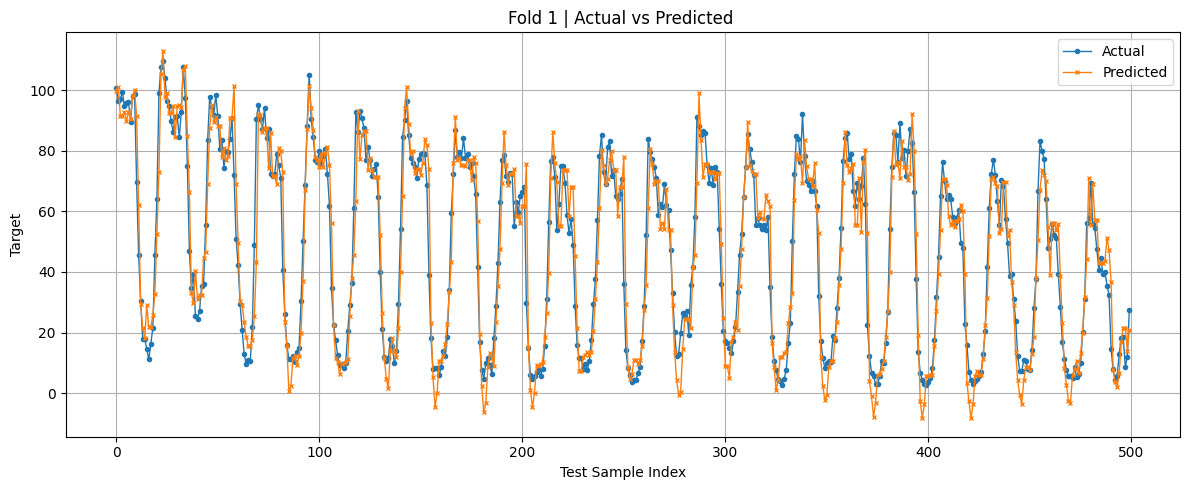

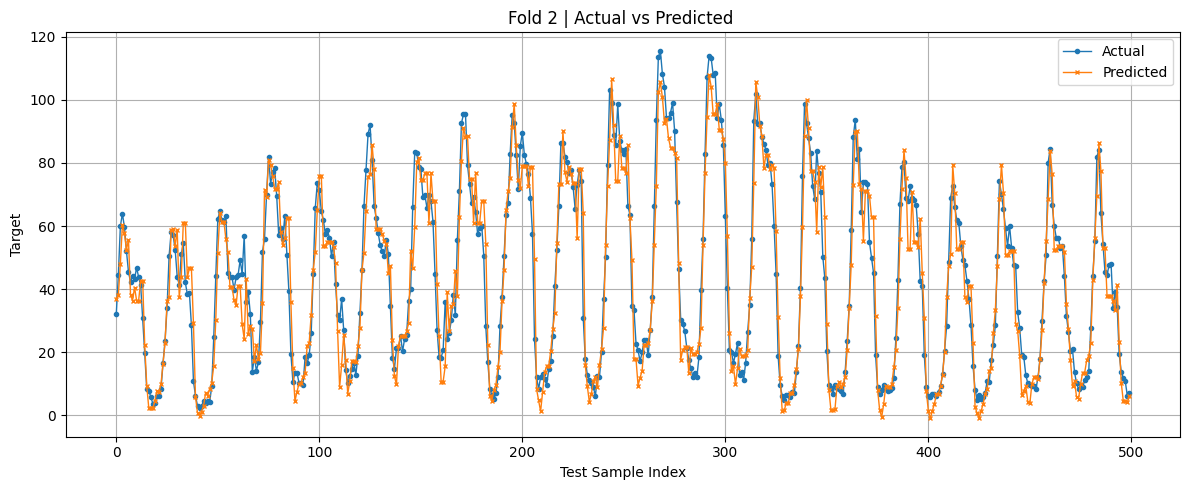

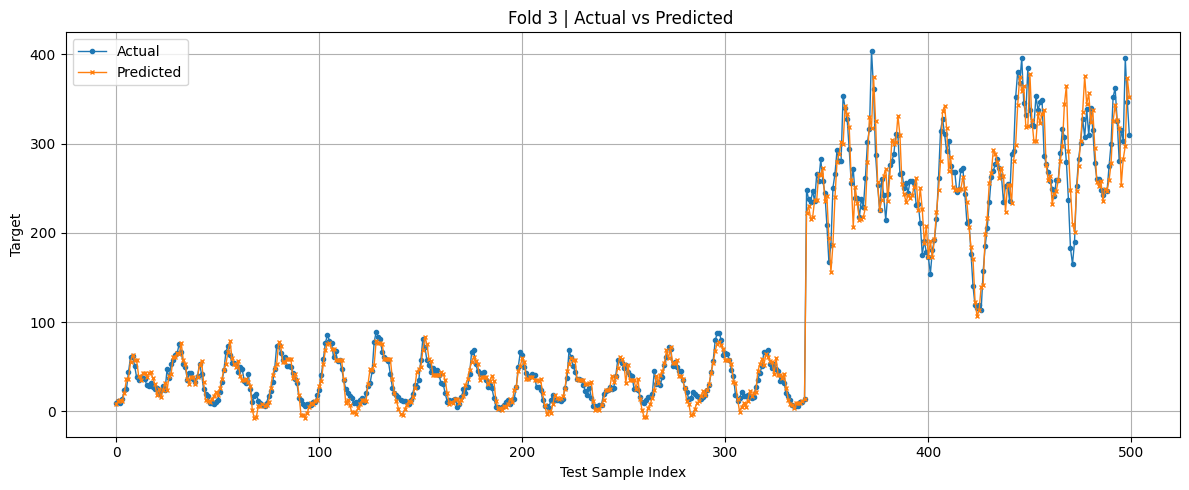

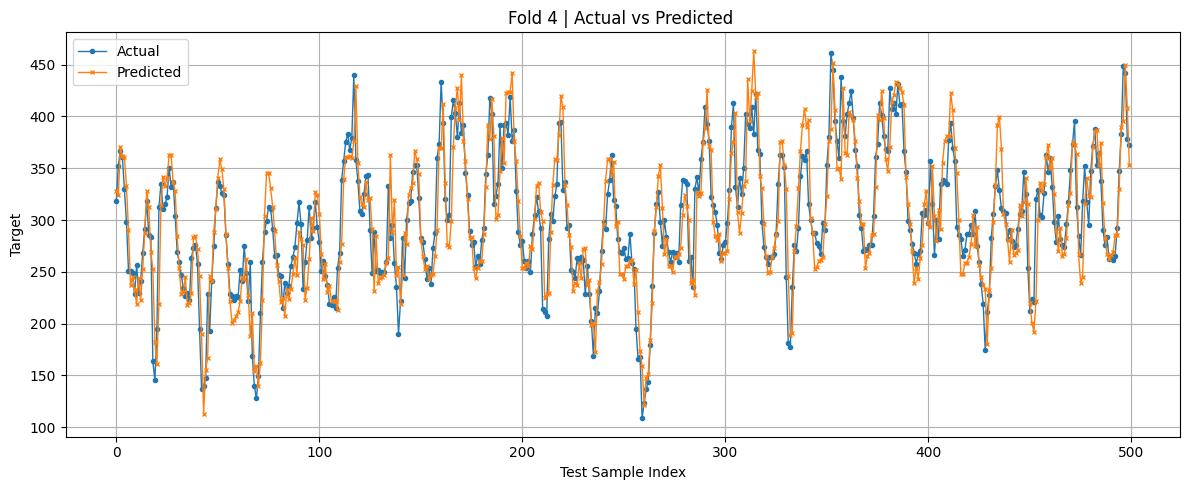

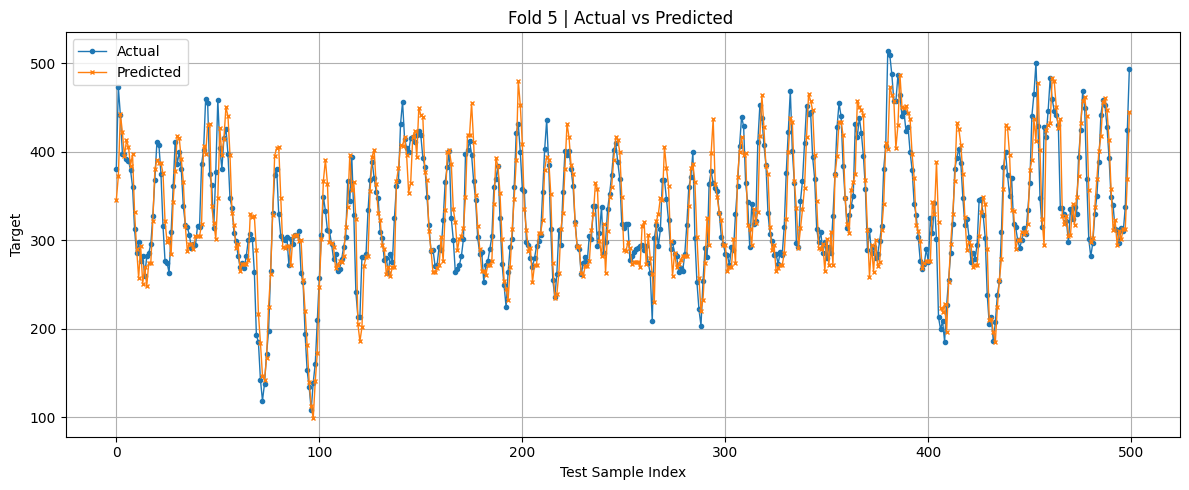

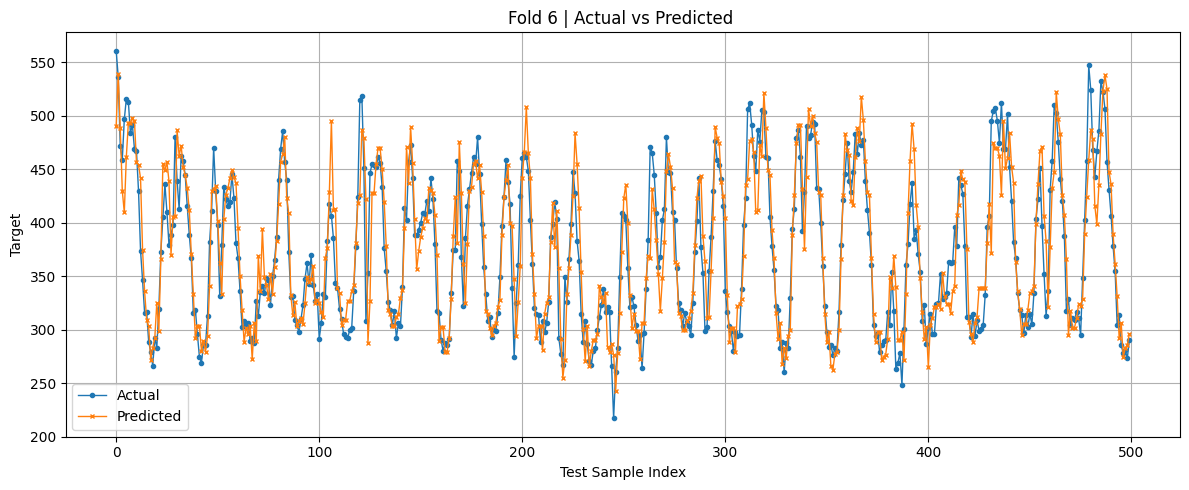

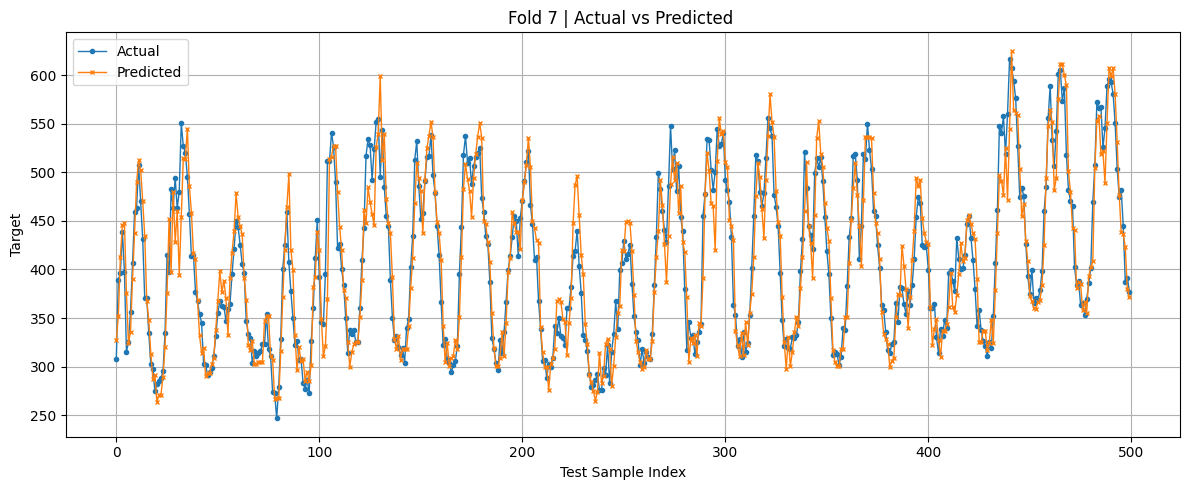

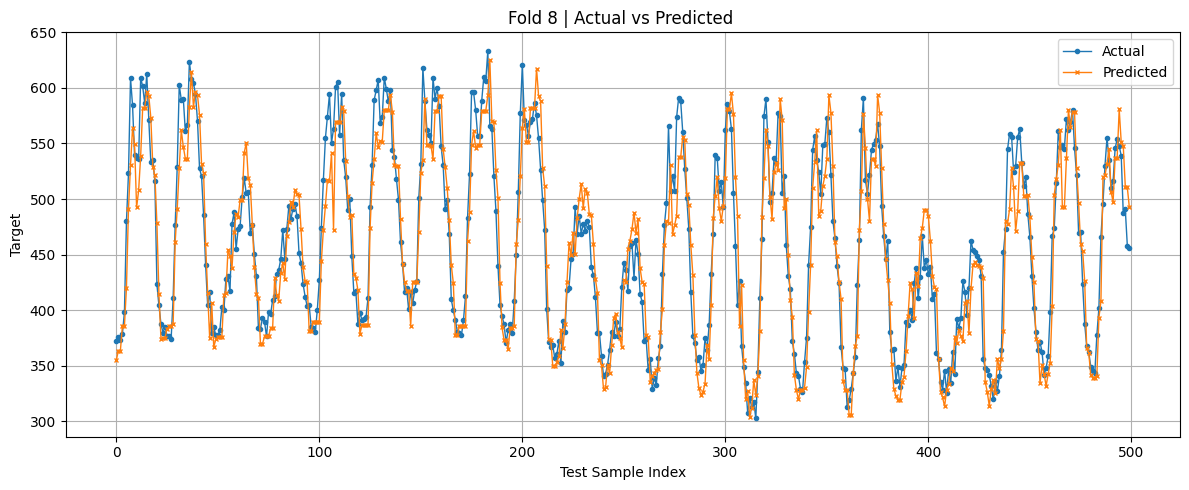

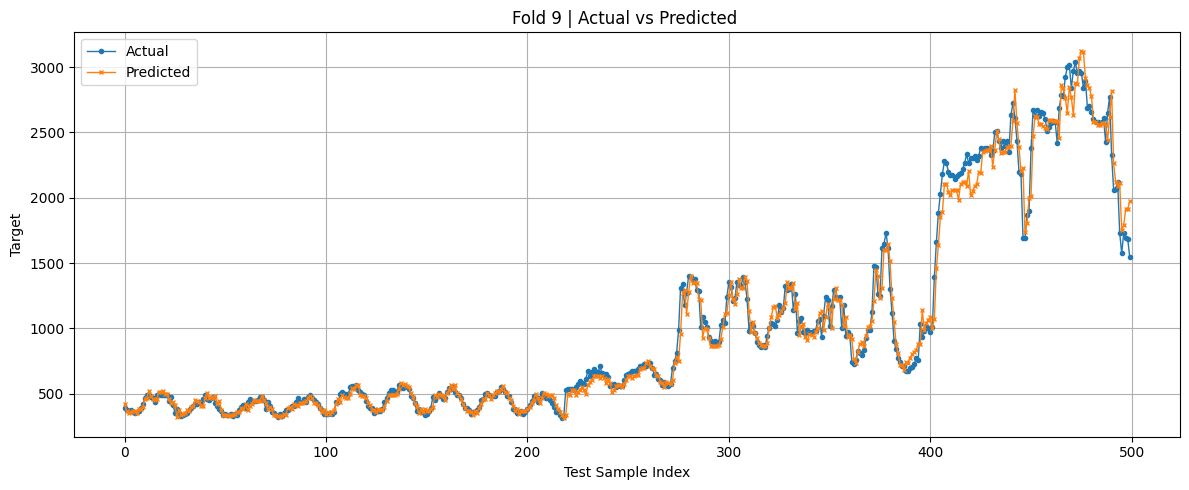

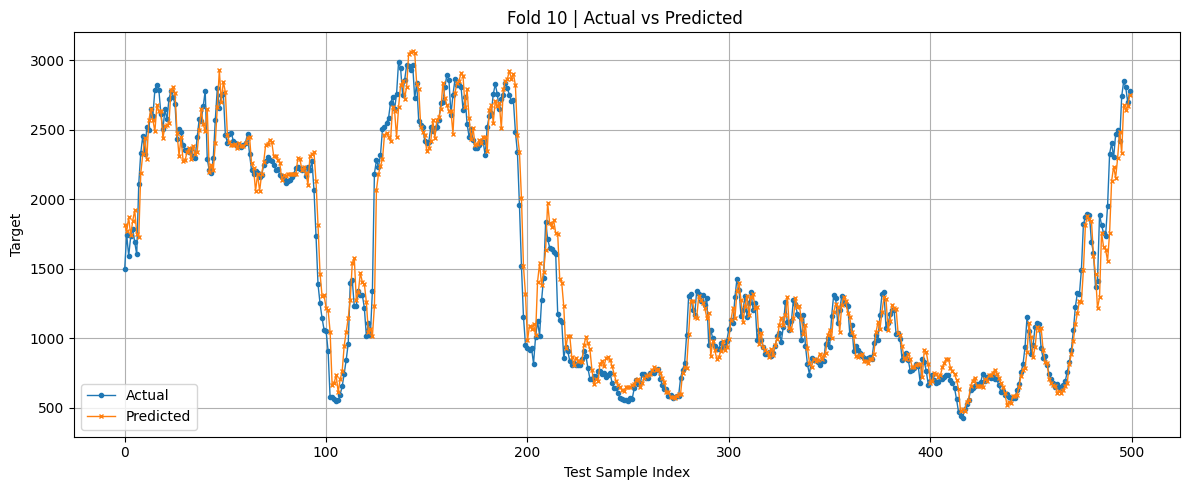

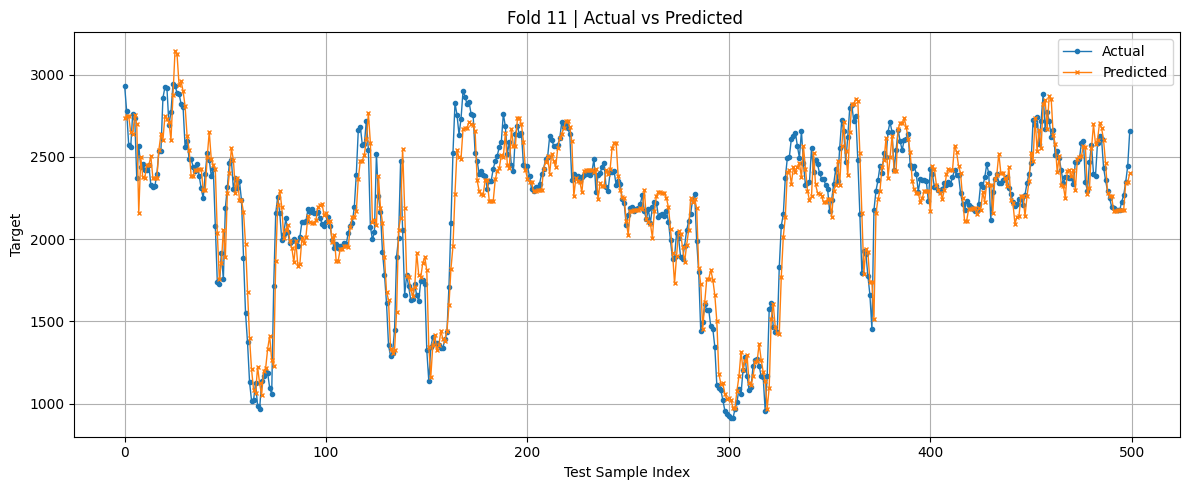

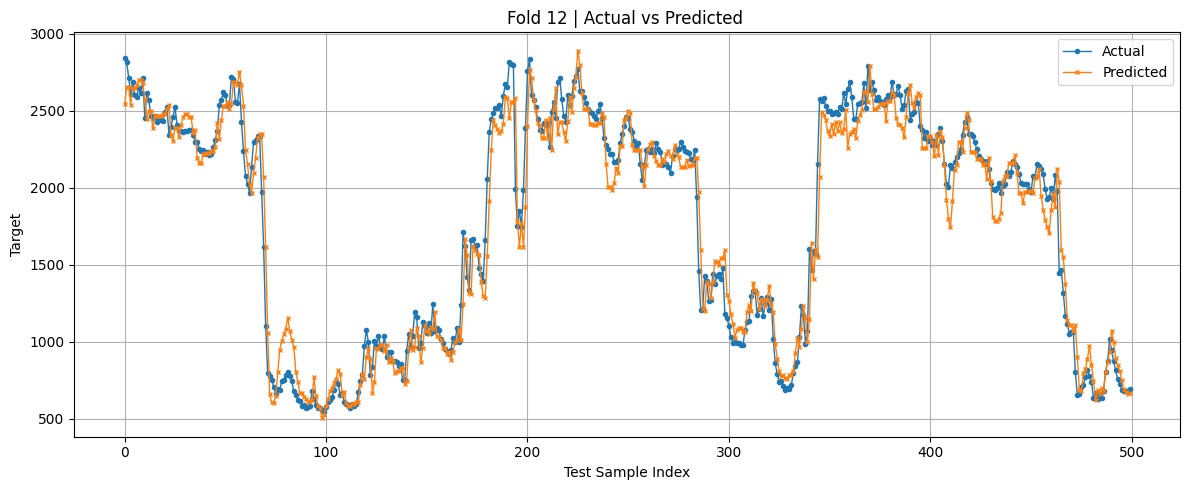

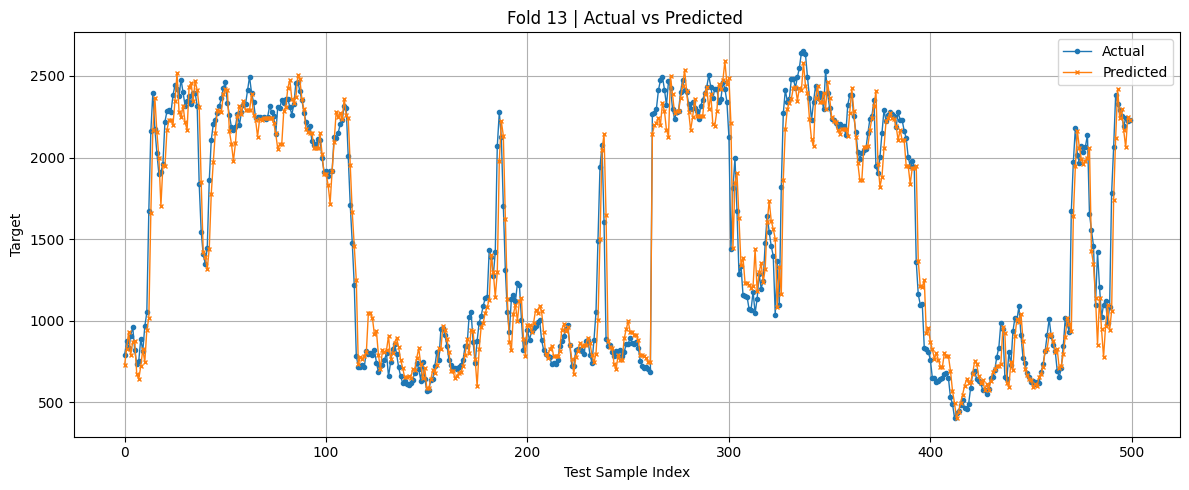

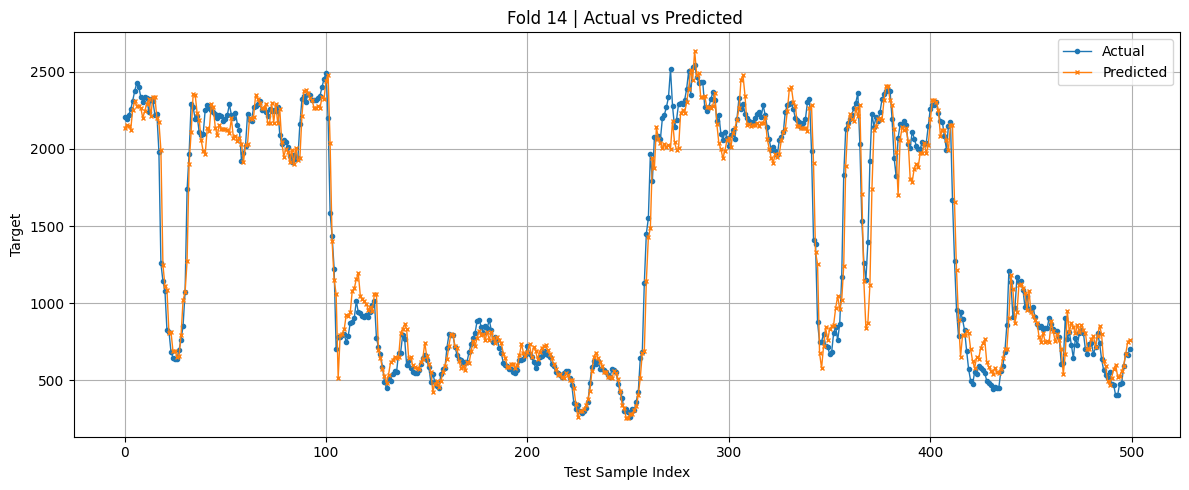

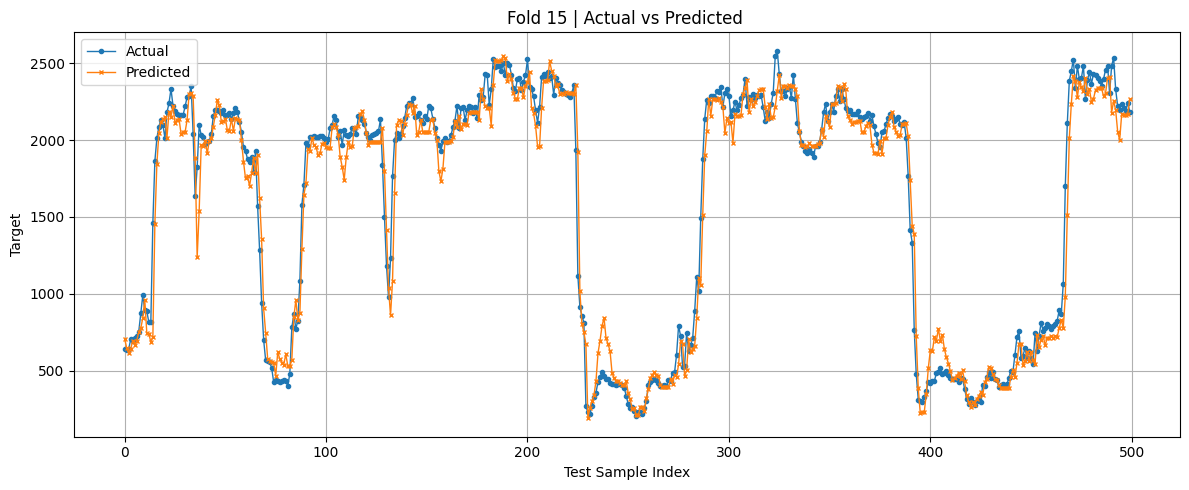

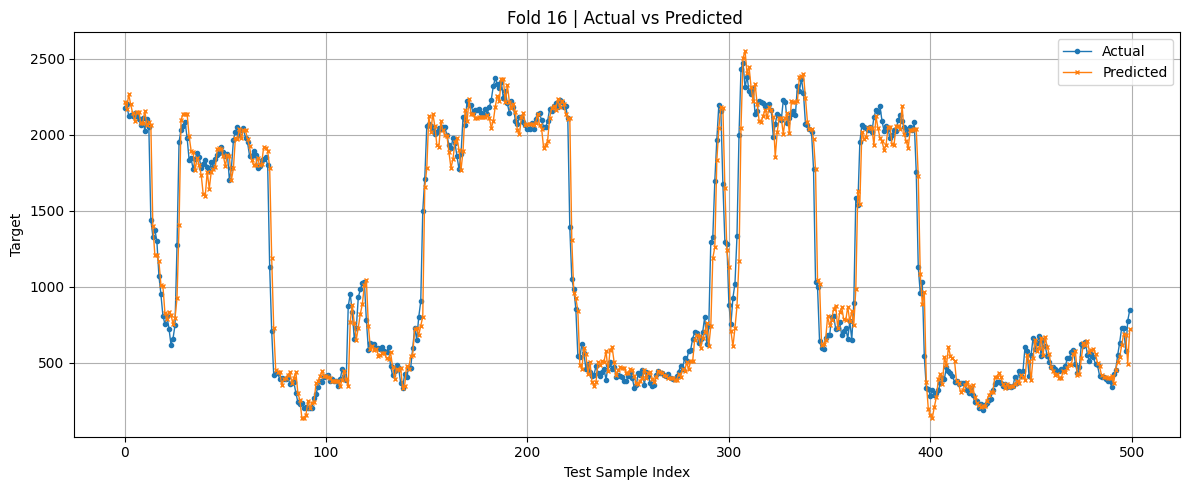

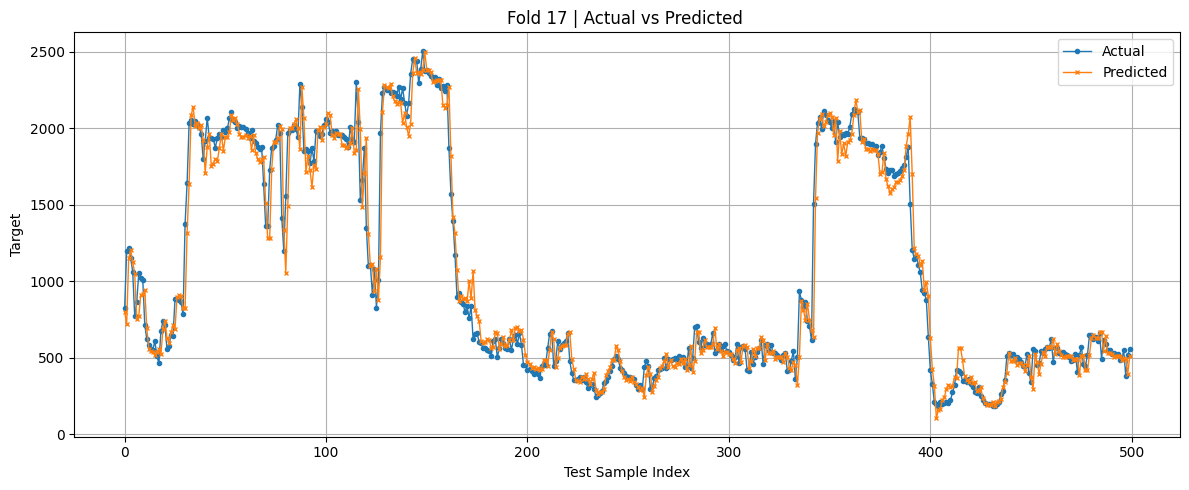

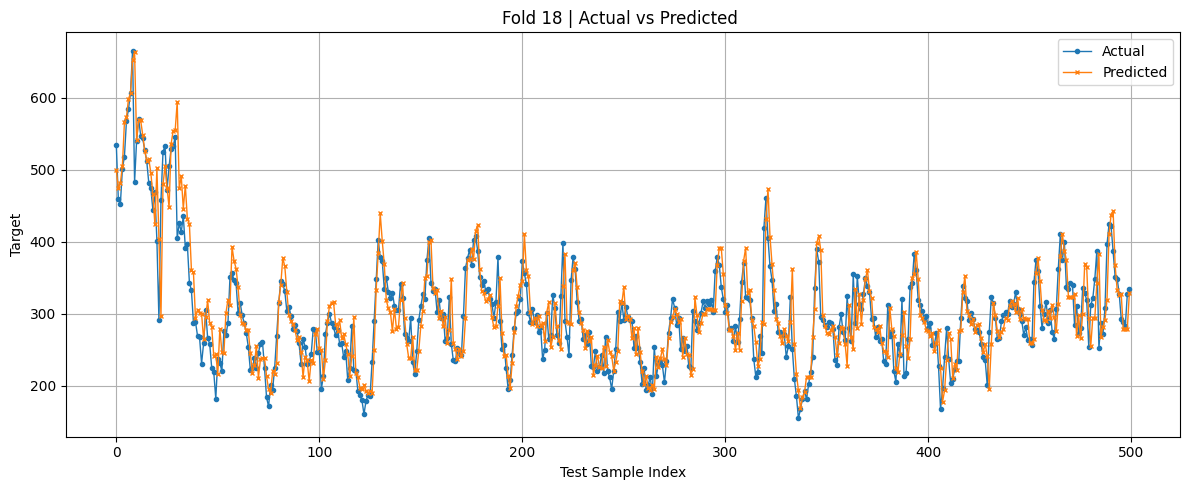

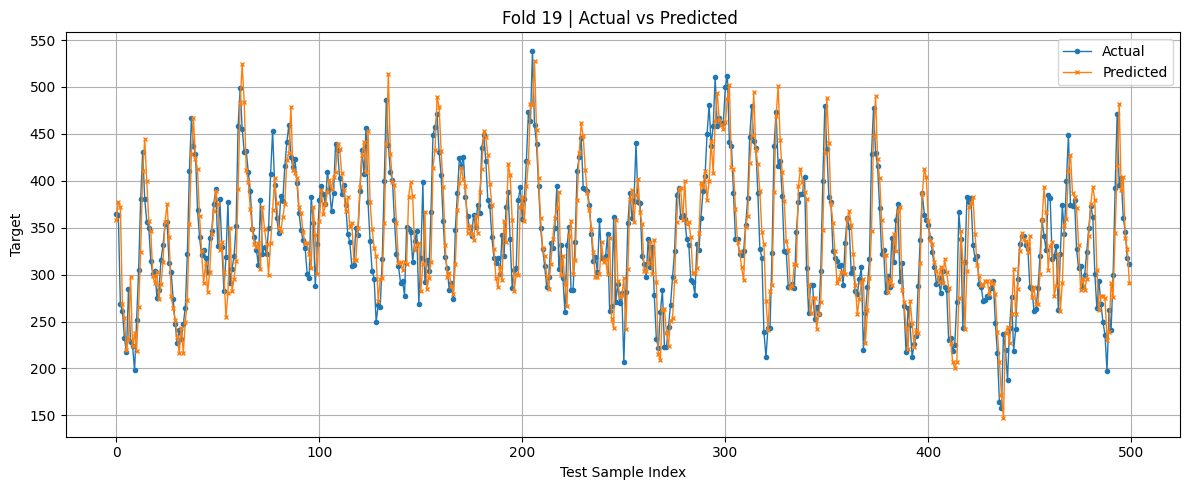

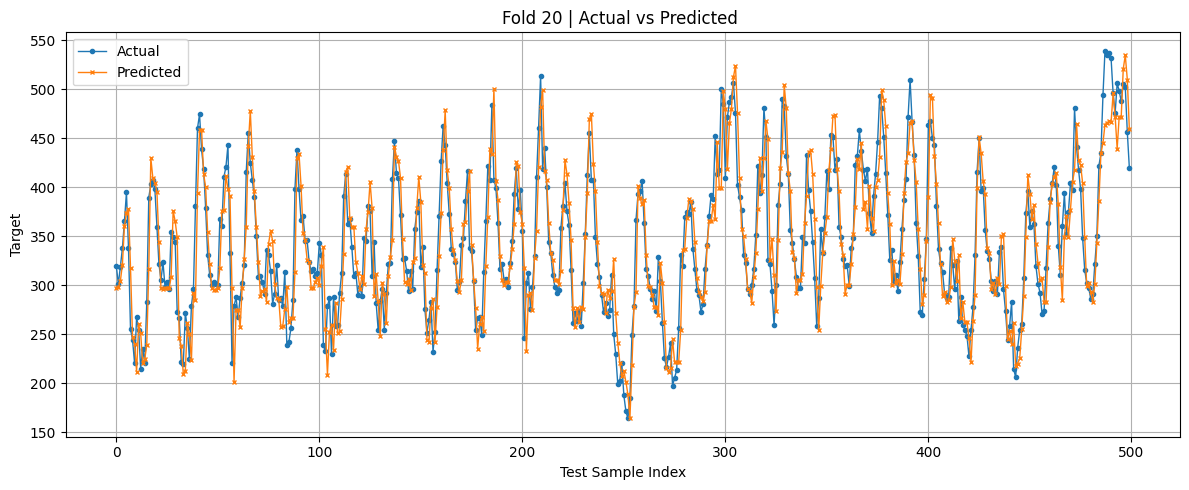

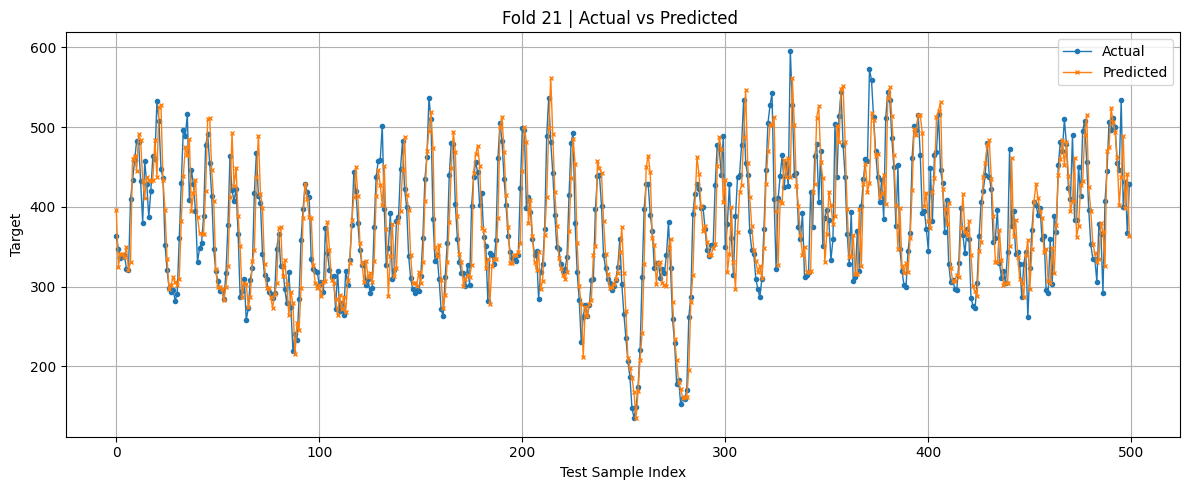

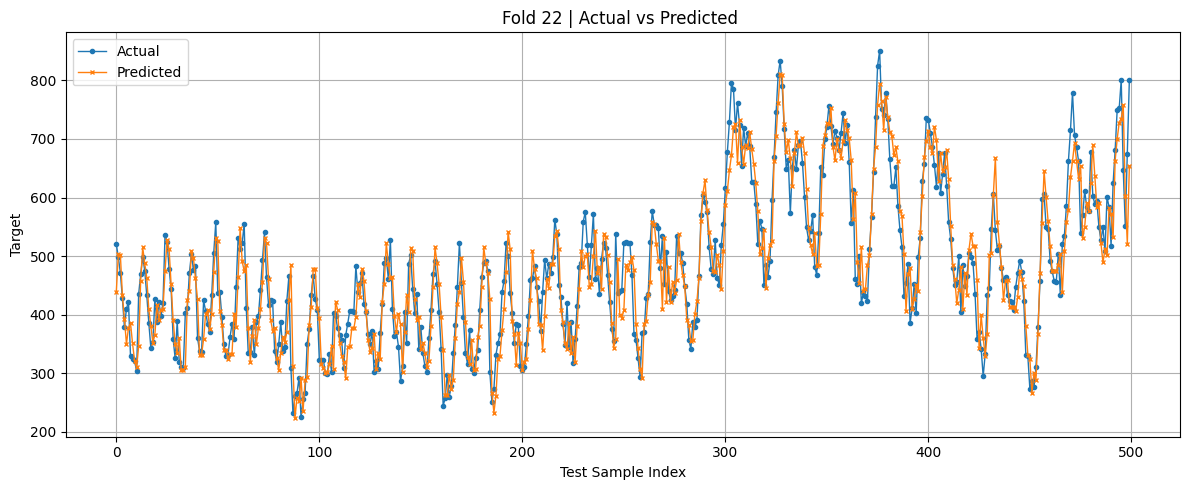

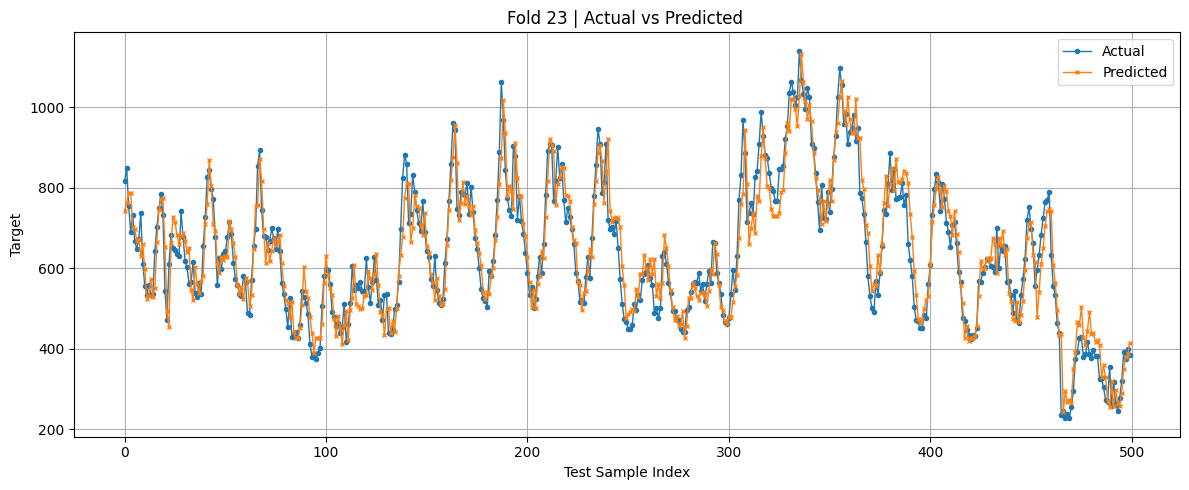

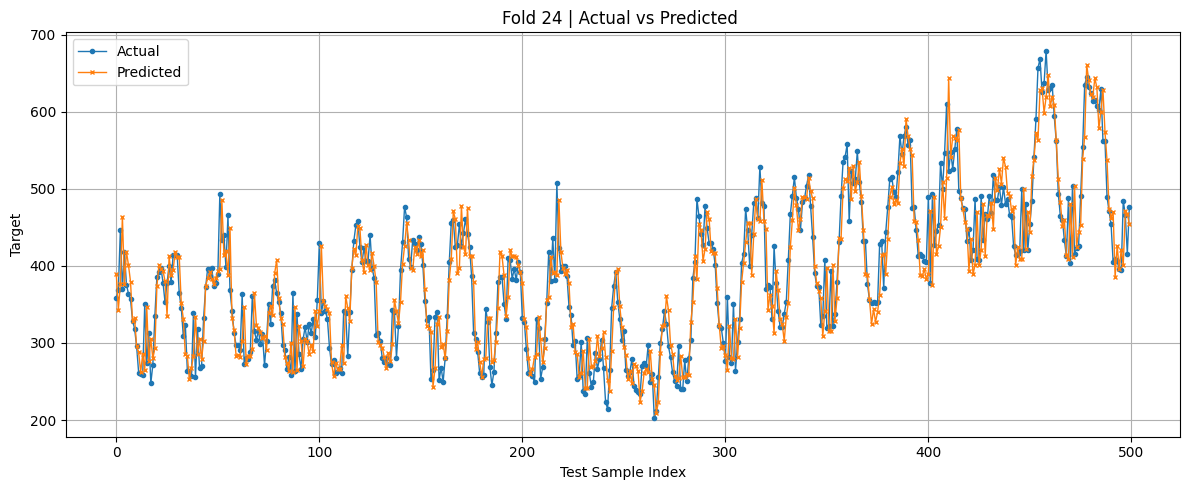

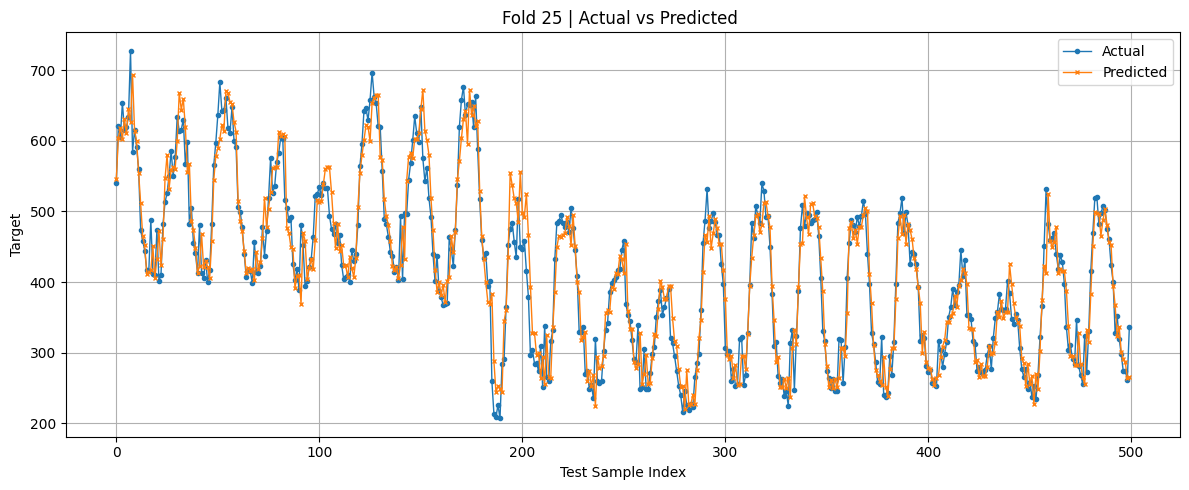

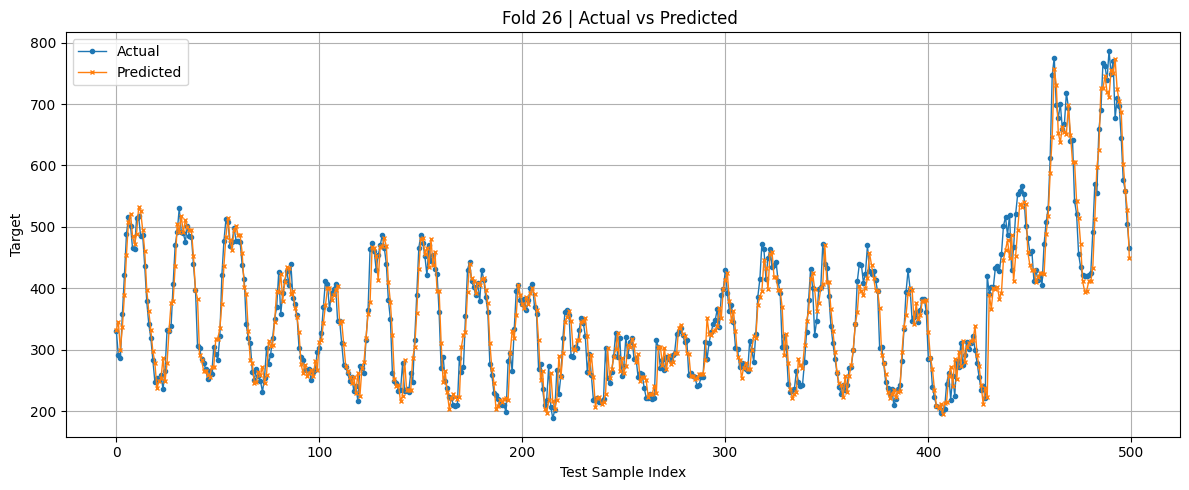

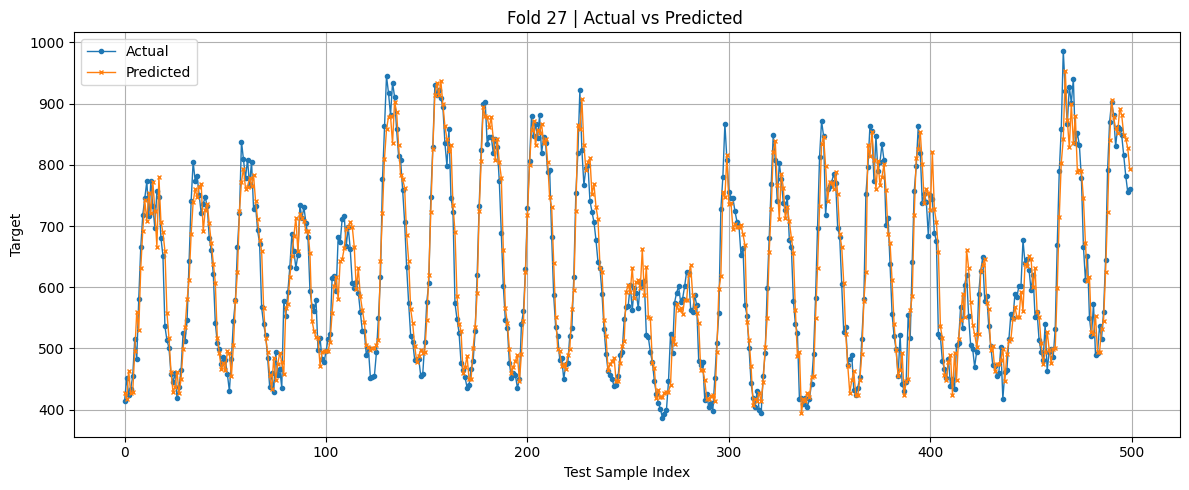

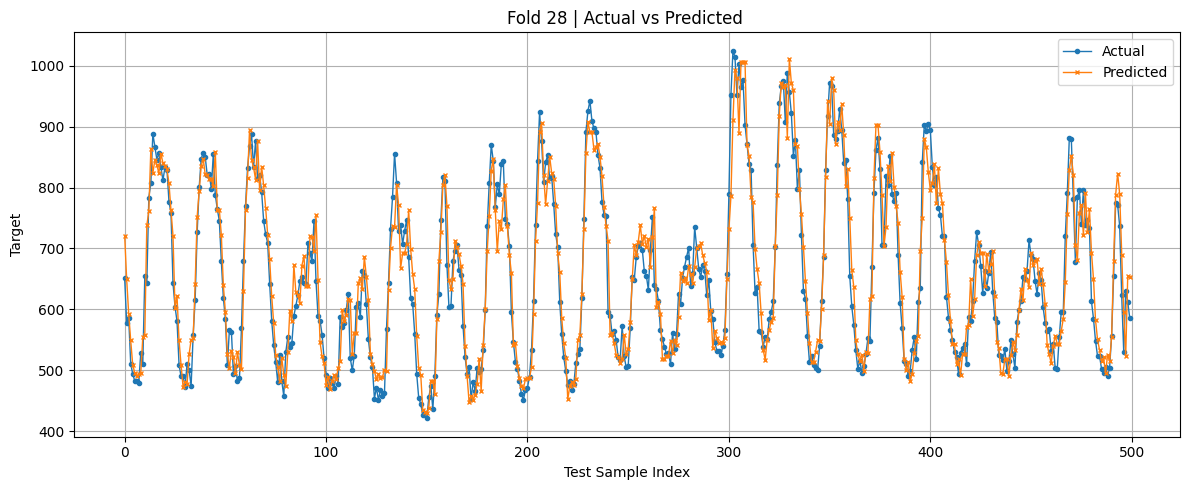

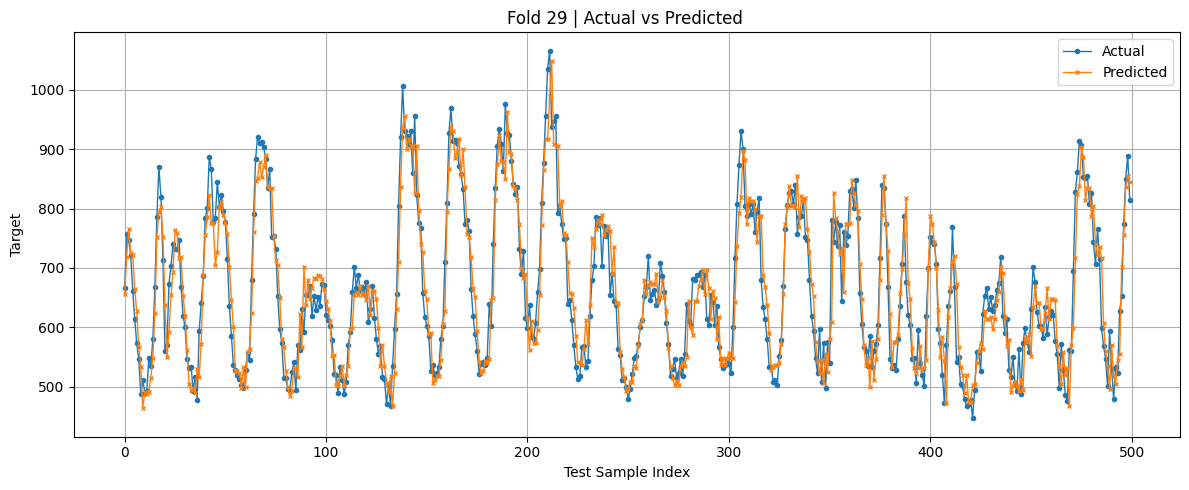

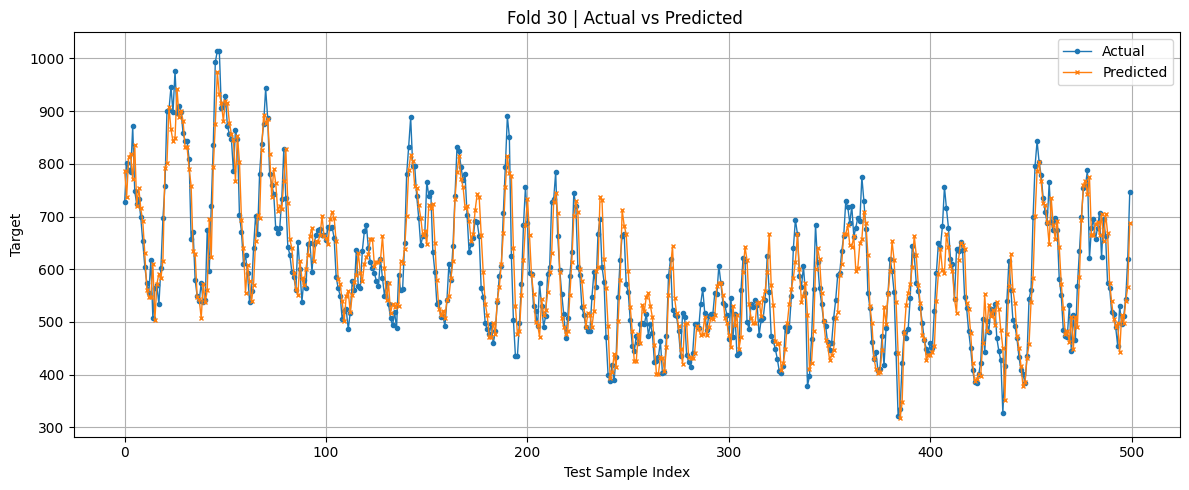

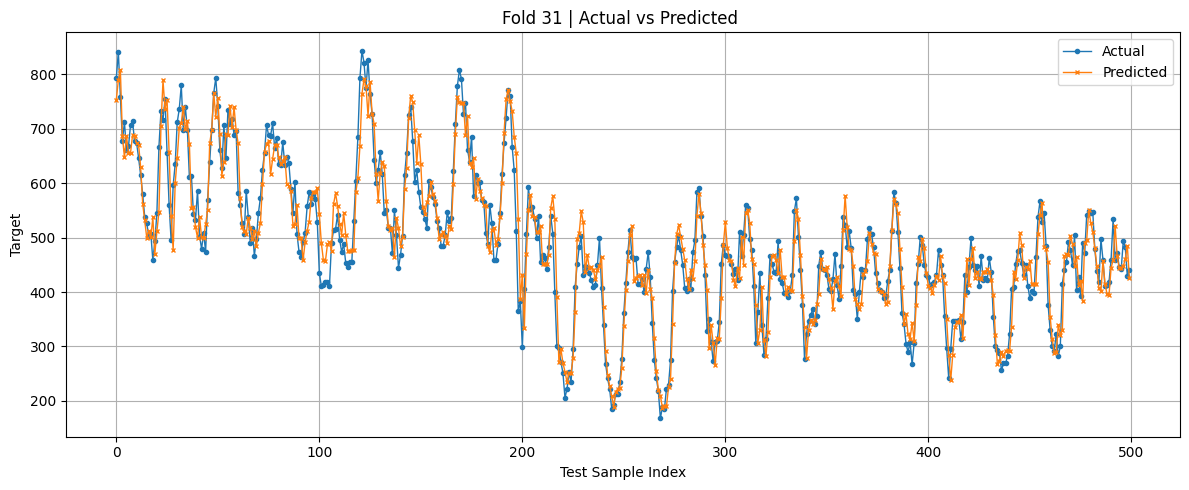

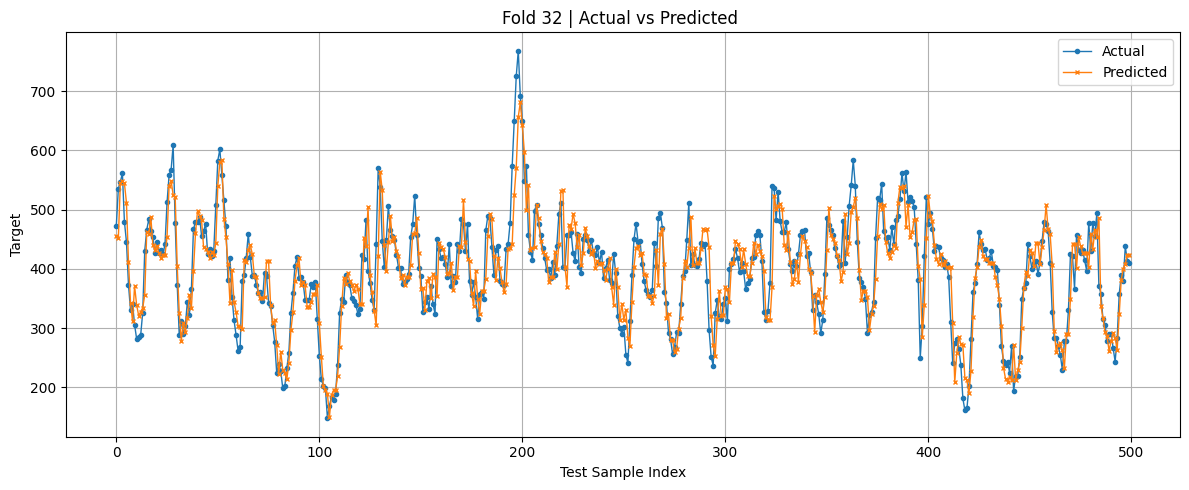

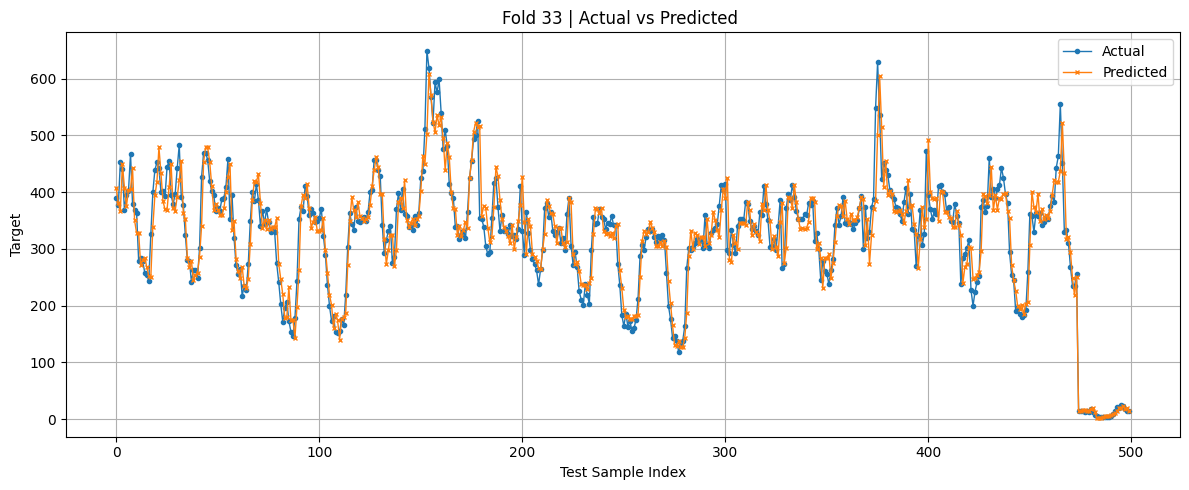

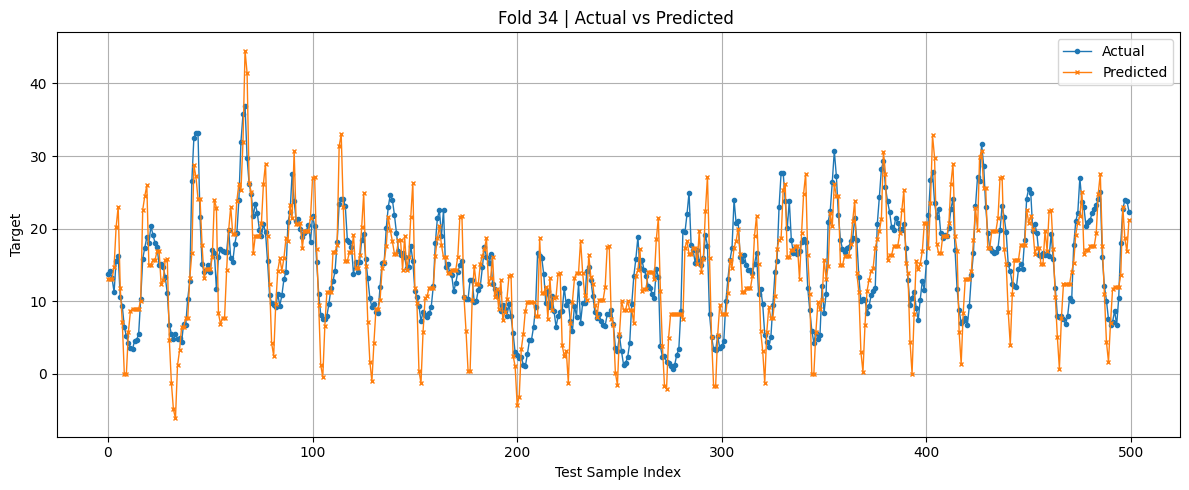

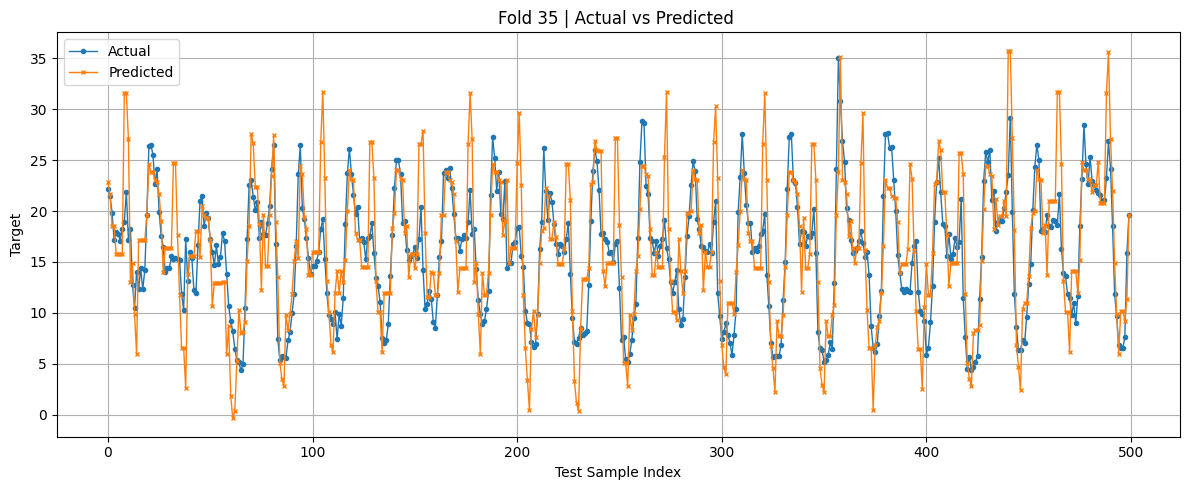

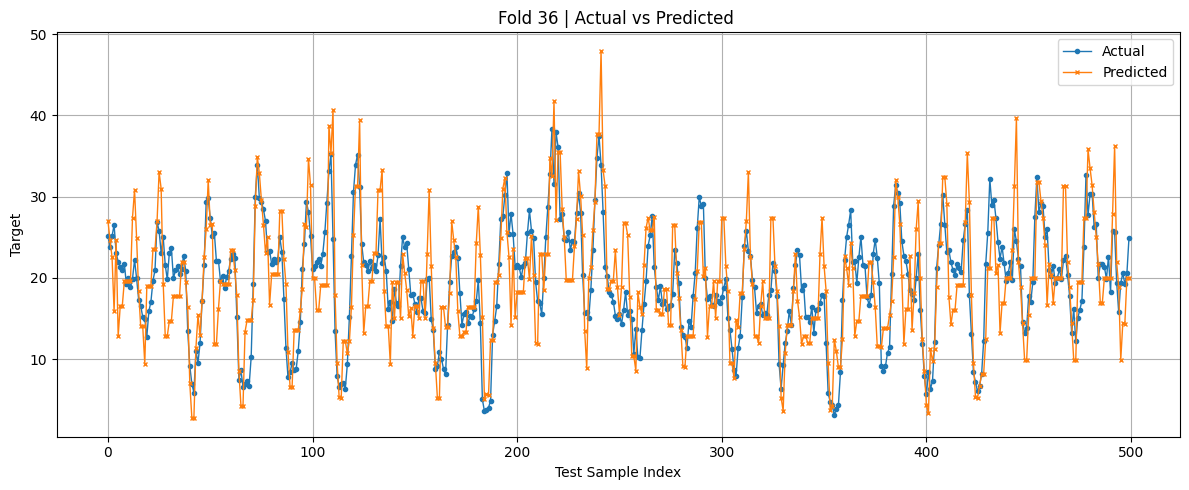

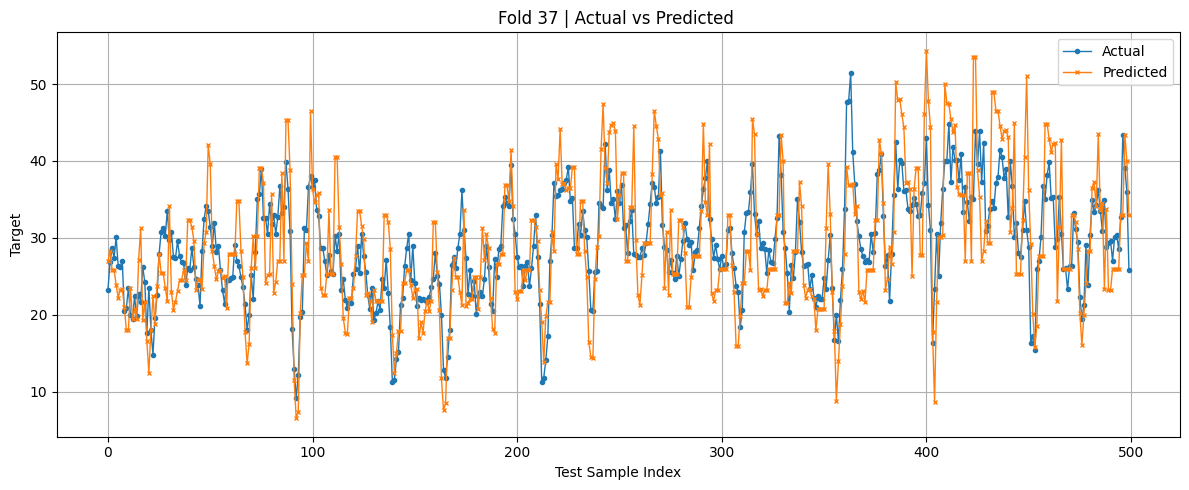

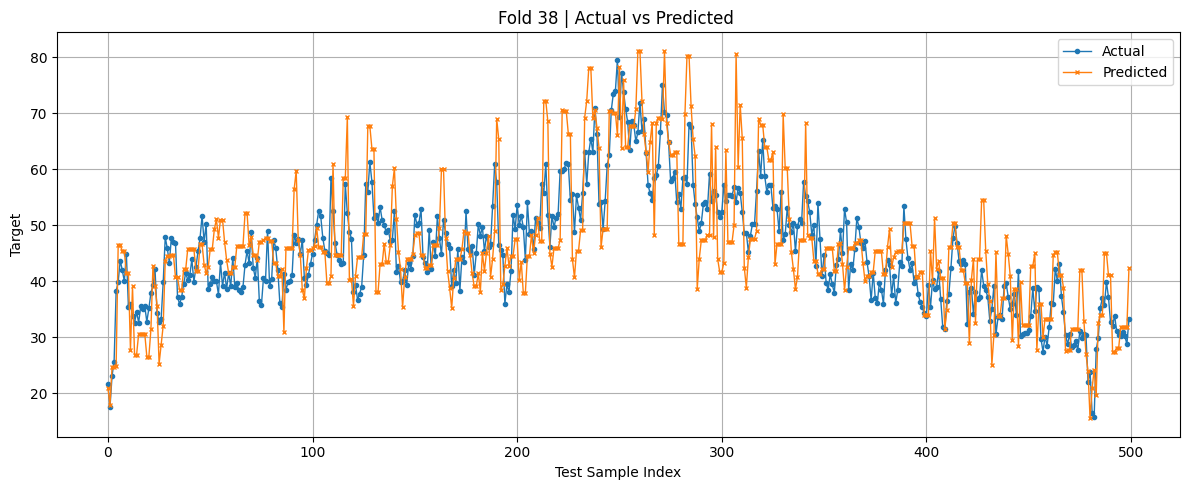

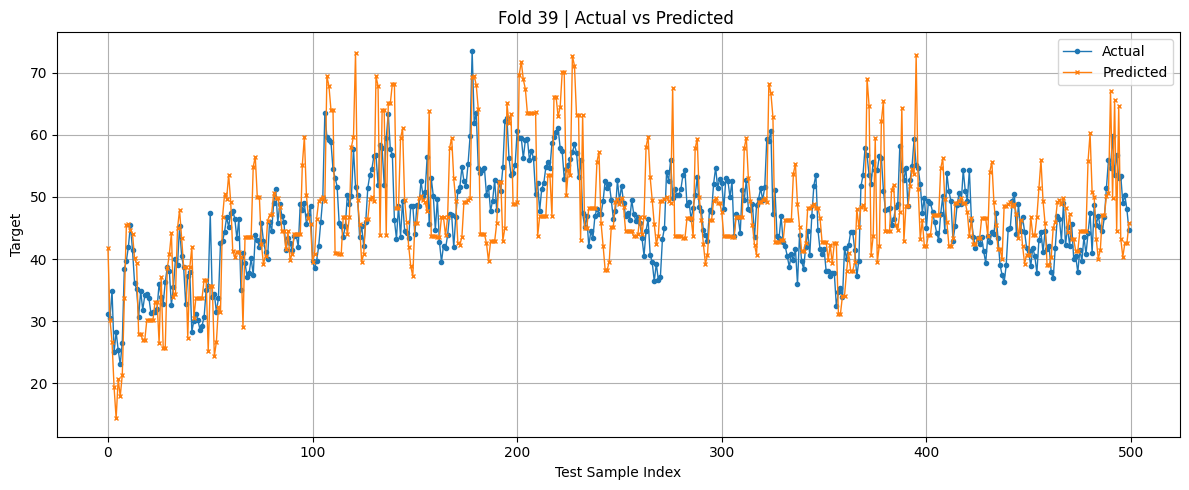

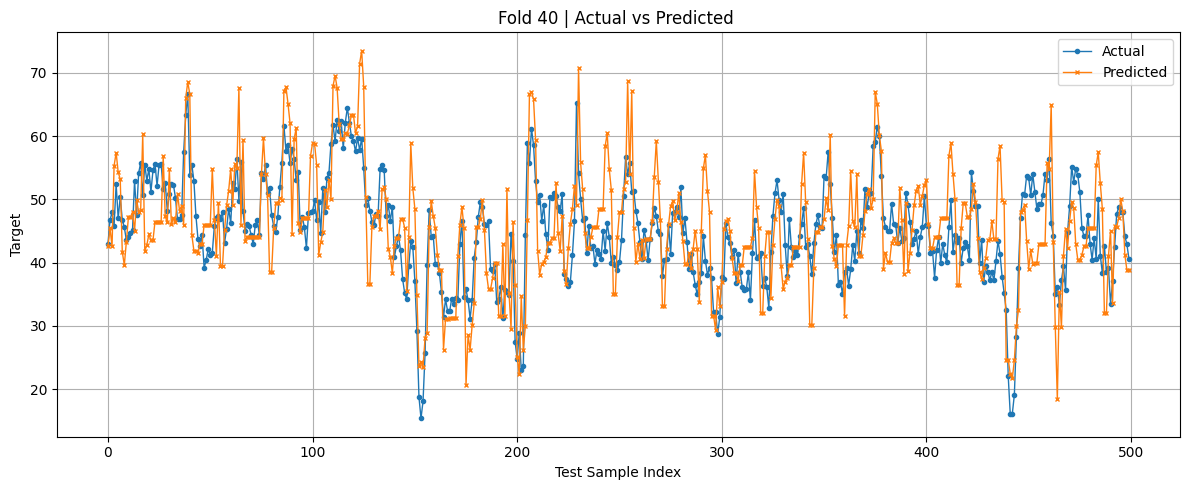

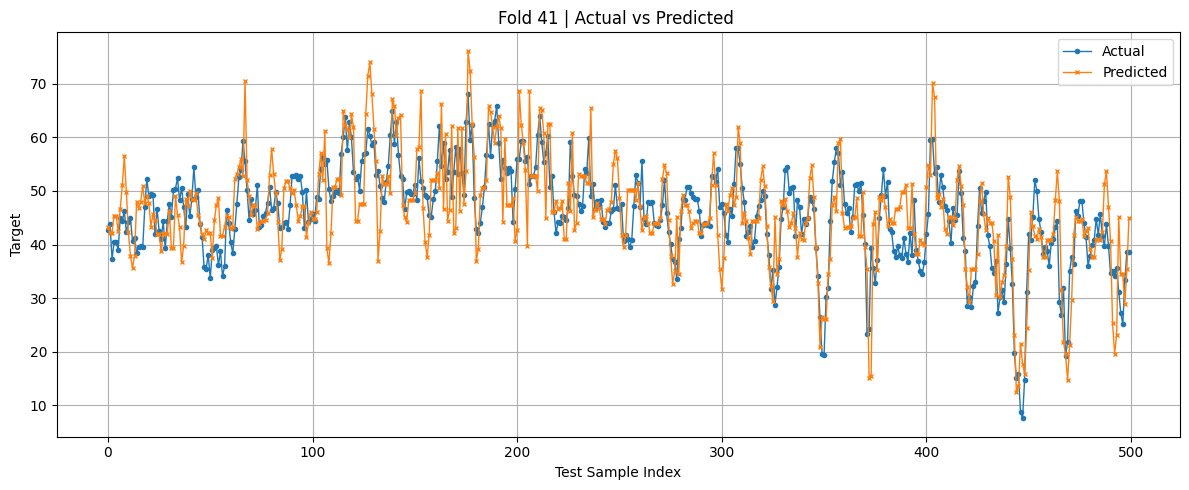

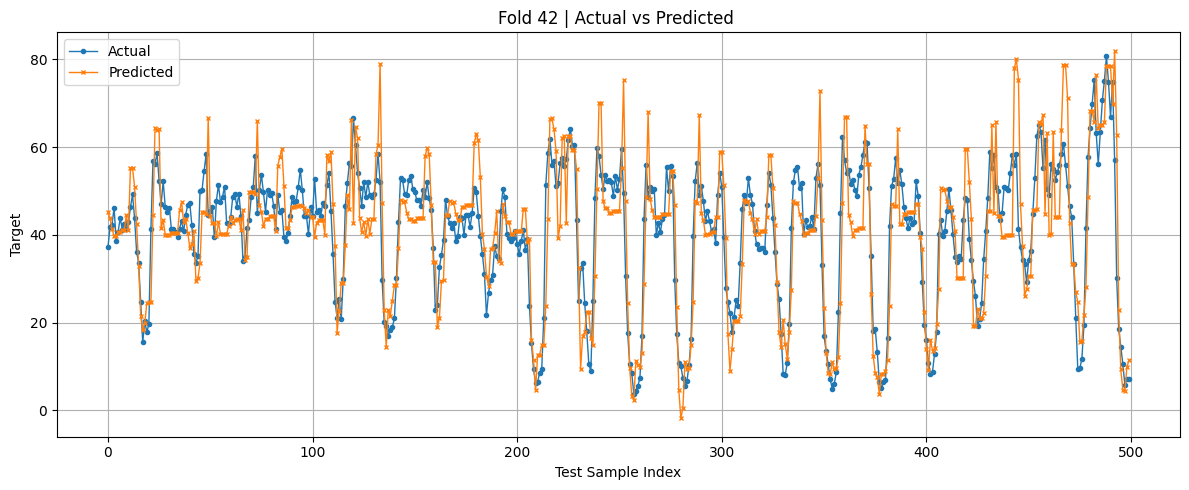

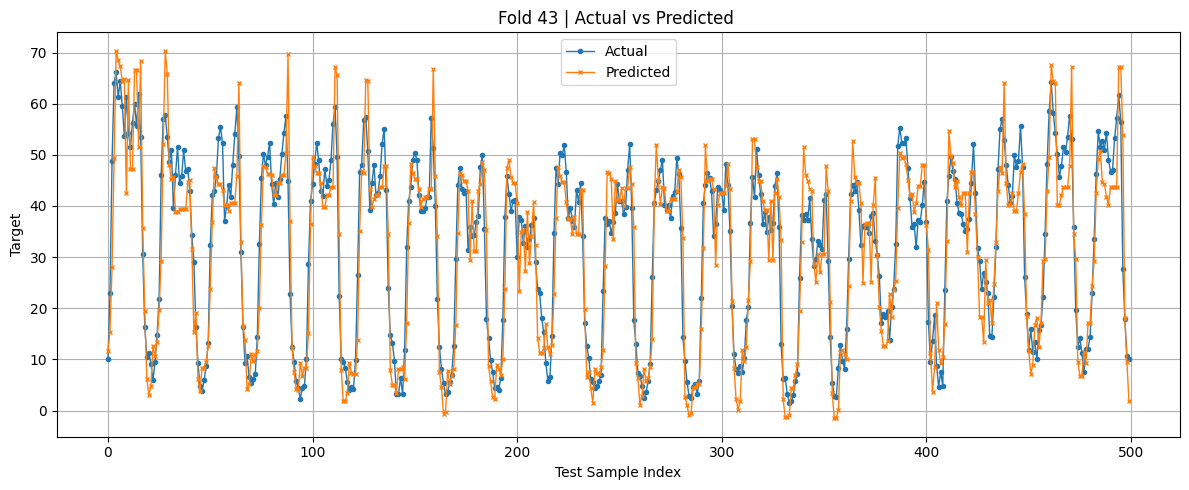

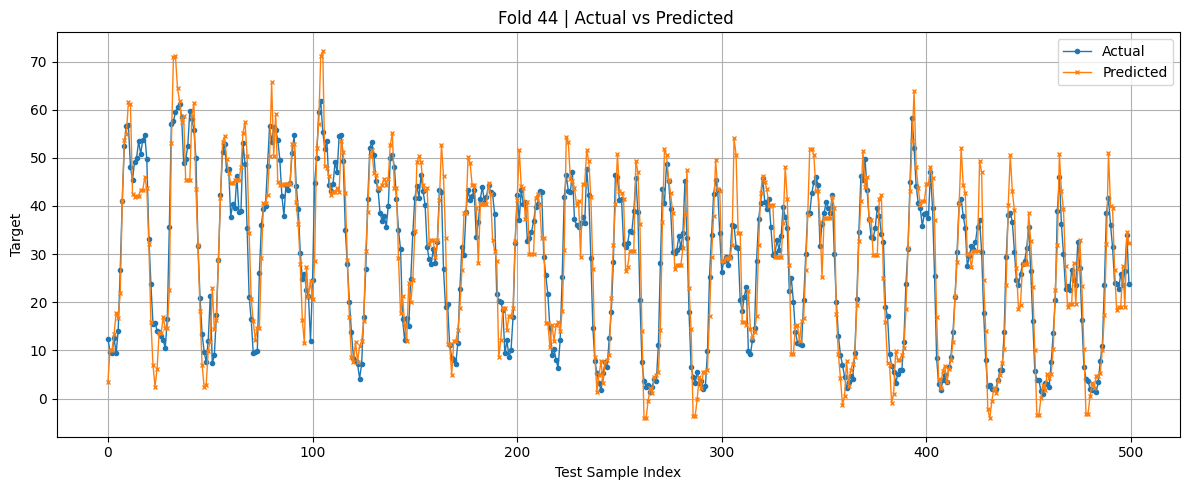

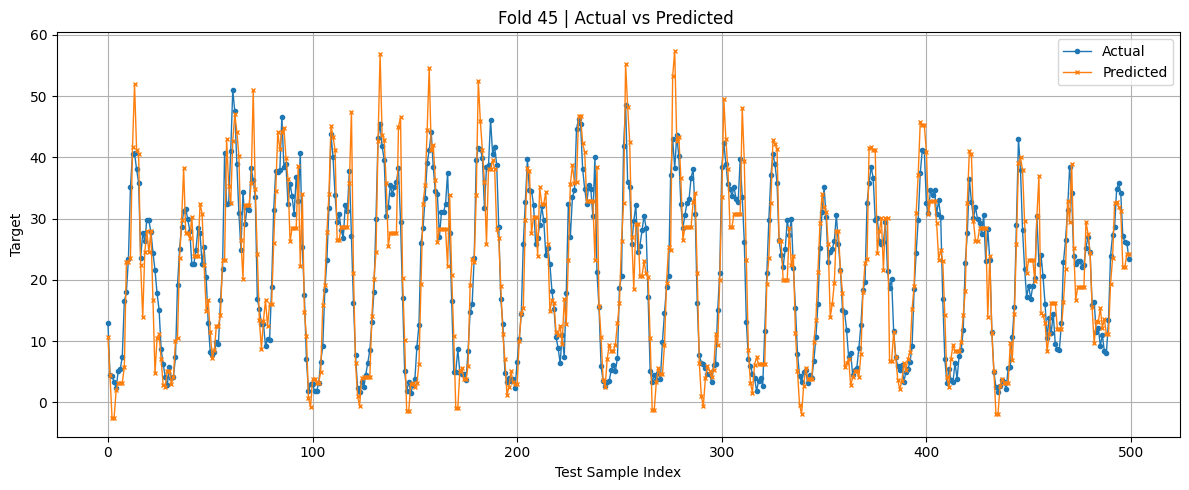

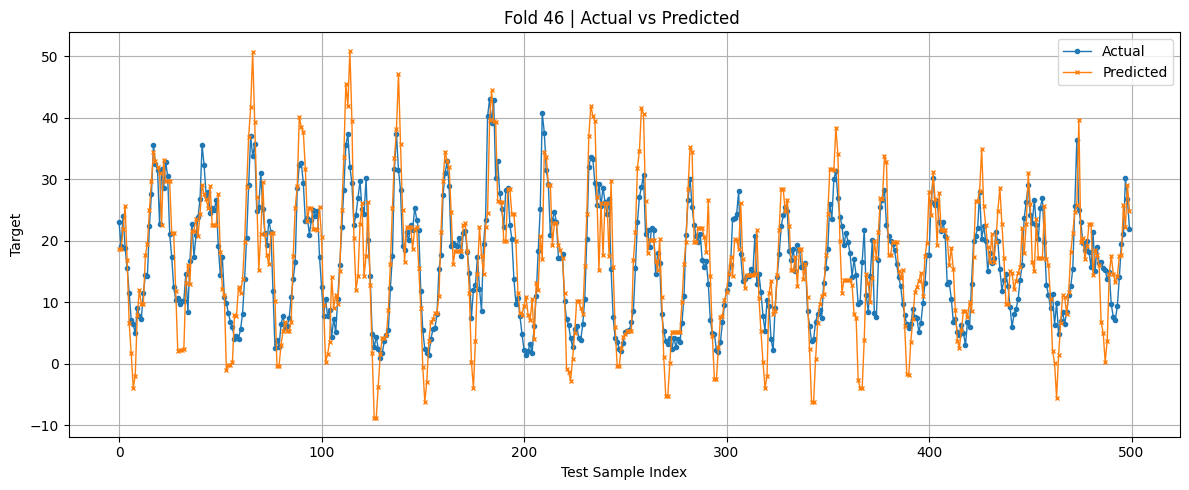

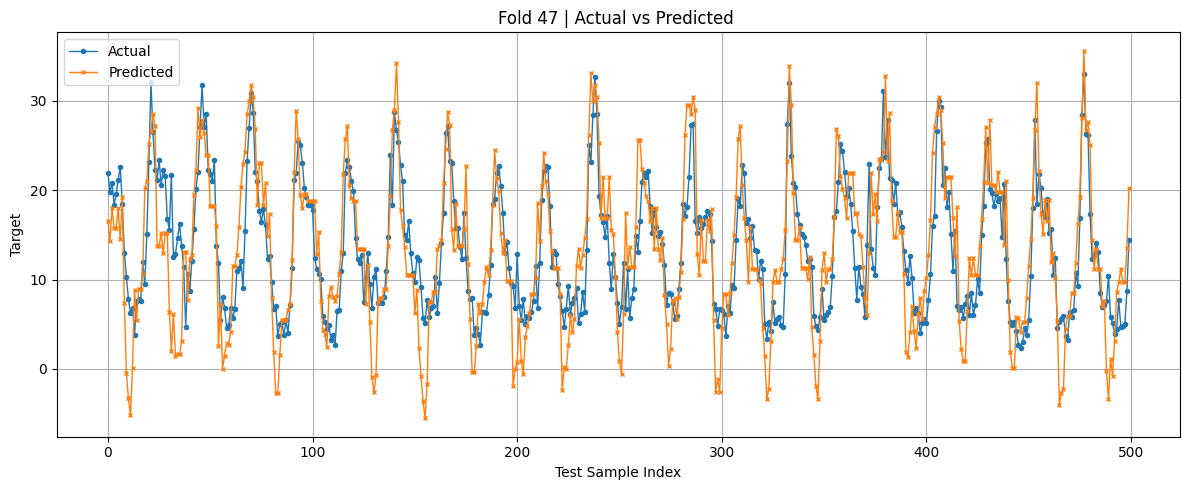

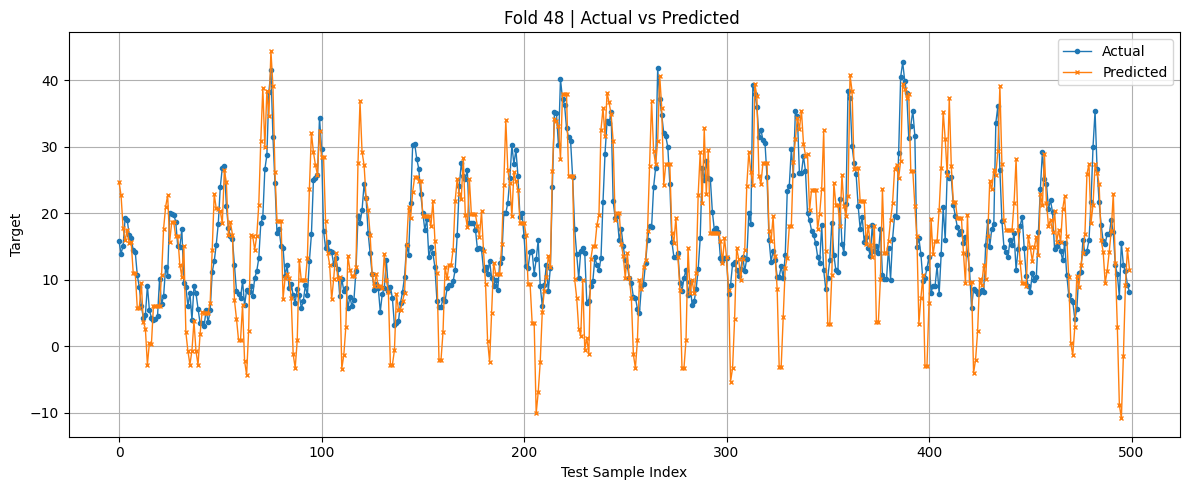

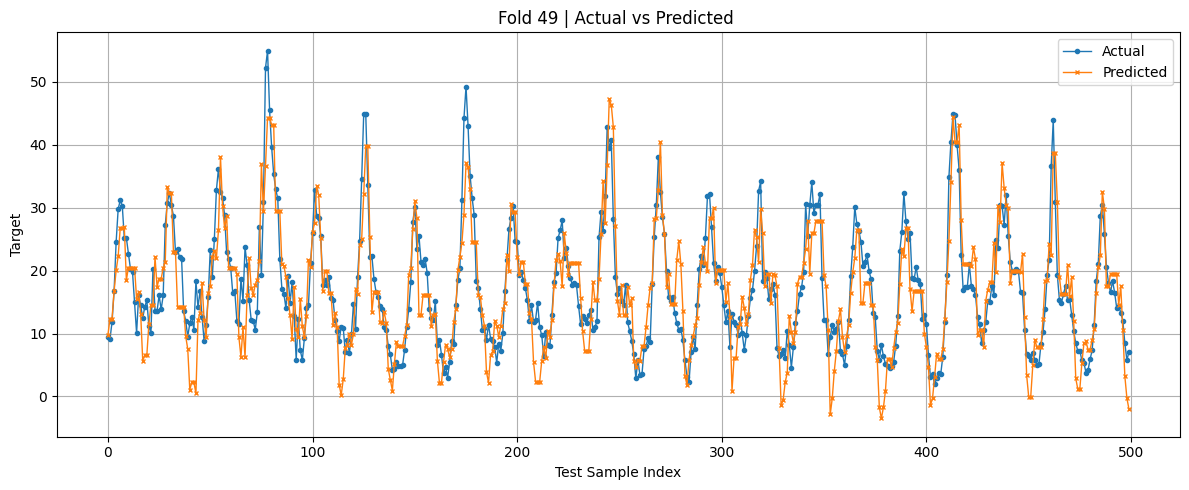

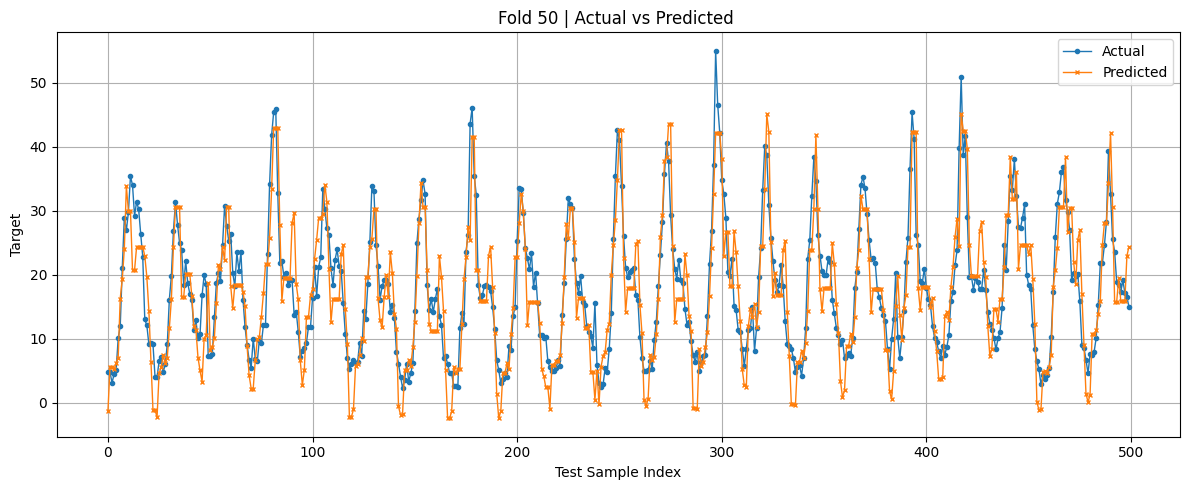

In [14]:

# Filter to consumption
consumption_df = merged_df[merged_df["is_consumption"] == True].copy()

# Additional Lag Features
lags = [1, 6, 12, 24]
for l in lags:
    consumption_df[f"target_lag_{l}h"] = consumption_df.groupby("prediction_unit_id")["target"].shift(l)

# Rolling Mean Features
rolling_windows = [6, 12, 24]
for w in rolling_windows:
    consumption_df[f"target_roll_mean_{w}h"] = (
        consumption_df.groupby("prediction_unit_id")["target"].rolling(w).mean().reset_index(0, drop=True)
    )

# Lead Weather Features (6 hours ahead)
leads = [6]
for lead in leads:
    consumption_df[f"temp_lead_{lead}h"] = (
        consumption_df.groupby("prediction_unit_id")["daily_avg_temp"].shift(-lead)
    )
    consumption_df[f"radiation_lead_{lead}h"] = (
        consumption_df.groupby("prediction_unit_id")["daily_avg_radiation"].shift(-lead)
    )

# Drop NaNs from engineered features
lead_lag_features = [
    f"target_lag_{l}h" for l in lags
] + [
    f"target_roll_mean_{w}h" for w in rolling_windows
] + [
    f"temp_lead_{l}h" for l in leads
] + [
    f"radiation_lead_{l}h" for l in leads
]

base_features = [
    "hour", "dayofweek", "month",
    "lowest_price_per_mwh", "highest_price_per_mwh",
    "daily_avg_temp", "daily_avg_radiation", "daily_avg_cloudcover", "daily_avg_wind"
]

features = base_features + lead_lag_features

# Clean Data
consumption_df = consumption_df.dropna(subset=features + ["target"])
X = consumption_df[features].values
y = consumption_df["target"].values

# Forecasting Utilities
def rolling_window_split(X, y, train_size, test_size, max_folds=3):
    n_samples = len(X)
    for fold in range(max_folds):
        start = fold * test_size
        train_end = start + train_size
        test_end = train_end + test_size
        if test_end > n_samples:
            break
        yield np.arange(start, train_end), np.arange(train_end, test_end)

def xgboost_forecast(X_train, y_train, X_test):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)
    model.fit(X_train, y_train)
    return model.predict(X_test)

# Run with Updated Features
train_size = 150000
test_size = 500

for fold, (train_idx, test_idx) in enumerate(rolling_window_split(X, y, train_size, test_size, max_folds=50)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    y_pred = xgboost_forecast(X_train, y_train, X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Plot Prediction vs Actual
    plt.figure(figsize=(12, 5))
    plt.plot(y_test, label="Actual", marker='o', markersize=3, linewidth=1)
    plt.plot(y_pred, label="Predicted", marker='x', markersize=3, linewidth=1)
    plt.title(f"Fold {fold + 1} | Actual vs Predicted ")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Target")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Overall MAE: 8.2609


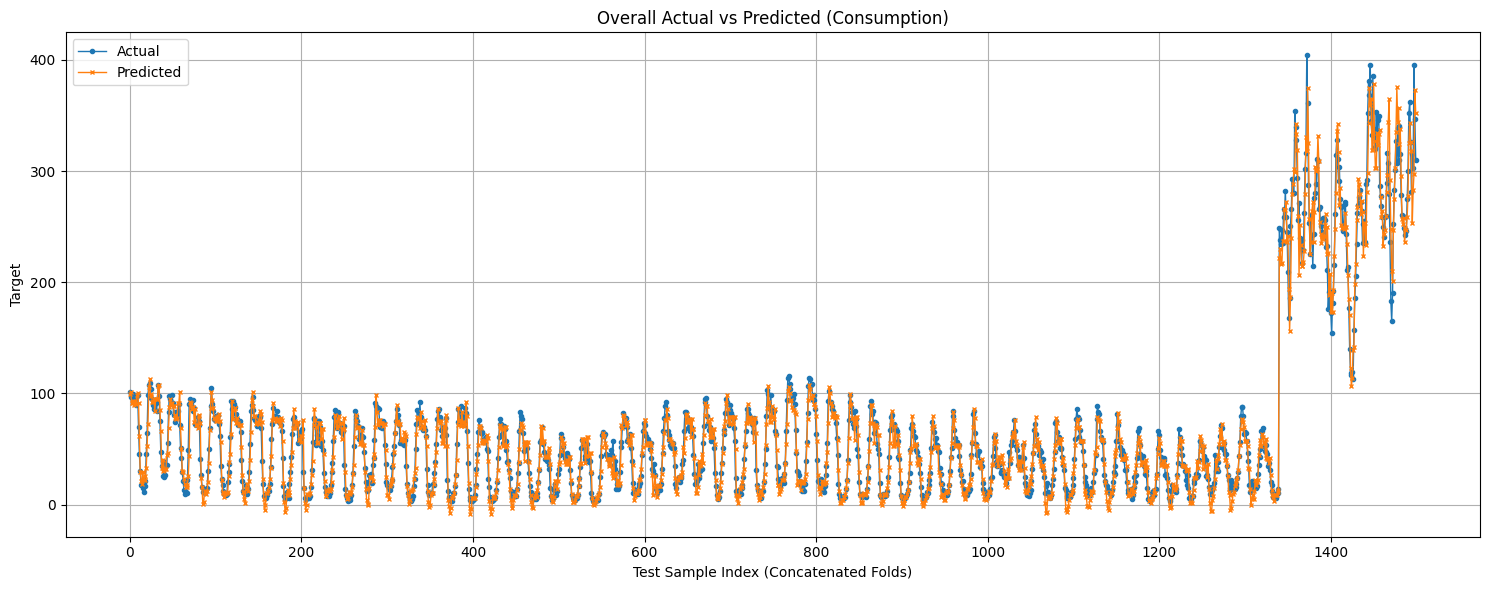

In [20]:

from sklearn.metrics import mean_squared_error, mean_absolute_error



all_y_test = []
all_y_pred = []

for fold, (train_idx, test_idx) in enumerate(rolling_window_split(X, y, train_size, test_size, max_folds=max_folds)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    y_pred = xgboost_forecast(X_train, y_train, X_test)

    all_y_test.append(y_test)
    all_y_pred.append(y_pred)

# Concatenate all fold results
all_y_test = np.concatenate(all_y_test)
all_y_pred = np.concatenate(all_y_pred)

# Compute overall metrics
mae = mean_absolute_error(all_y_test, all_y_pred)

print(f"Overall MAE: {mae:.4f}")

# Plot overall actual vs predicted
plt.figure(figsize=(15, 6))
plt.plot(all_y_test, label="Actual", marker='o', markersize=3, linewidth=1)
plt.plot(all_y_pred, label="Predicted", marker='x', markersize=3, linewidth=1)
plt.title(f"Overall Actual vs Predicted (Consumption)")
plt.xlabel("Test Sample Index (Concatenated Folds)")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
